In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14

In [3]:
dataset = pd.read_csv('AirPassengers.csv')
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset = pd.read_csv('AirPassengers.csv')
#dataset = dataset[-1096:]#314 for 2019 data
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format= True)
dataset = dataset.set_index(['Month'])
dataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
from datetime import datetime

### Exploring the dataset

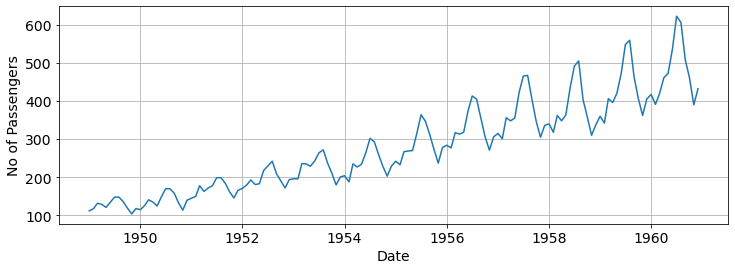

In [6]:
## plotting graph
plt.xlabel('Date')
plt.ylabel('No of Passengers')
plt.plot(dataset)
plt.show()

We needto check wheather the given time seriees is stationary or not...
There are different ways to do that...
    - Visually
    - Global vs Local tests
    - Augumented Dicky-Fuller test

In [7]:
rolmean = dataset.rolling(window = 12).mean()
rolstd = dataset.rolling(window = 12).std()
print(rolmean, rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


### checking the stationarity with Agumented Dickey Fuller Statistical Test

In [8]:
def test_stationarity(dataset):
## visually checking stationary........

    rolmean = dataset.rolling(window = 12).mean()
    rolstd = dataset.rolling(window = 12).std()
    #rolmean = dataset.rolling(window = 20).mean() # smoothing series - Moving average
    ## plotting graph
    plt.xlabel('Date')
    plt.ylabel('No of Passangers')
    plt.plot(dataset, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'rolling mean')
    plt.plot(rolstd, color = 'black', label = 'rolling std')
    plt.title('Rolling mean & Standard deviation')
    plt.legend()

    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey Fuller test is :')
    dftest = adfuller(dataset['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test statistic', 'p_value', '#Lags used', 'Number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['critical value (%s)'%key] = value

    print(dfoutput)

Results of Dickey Fuller test is :
Test statistic                   0.815369
p_value                          0.991880
#Lags used                      13.000000
Number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64


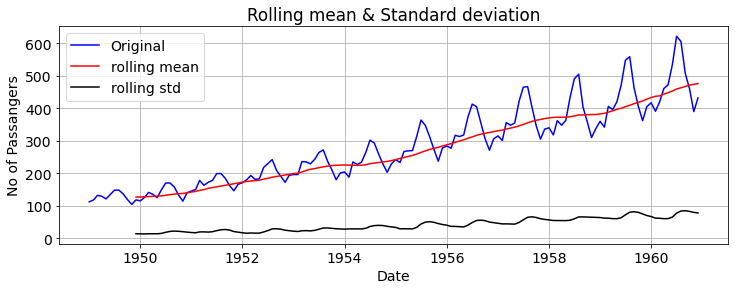

In [9]:
test_stationarity(dataset)

In the above series the mean is not constant and moreover the data has an increasing trend. So the data is not stationary. So we need to make it stationary by changing form of the data values.

Since p value of the test is not less than 0.05(significant value), so we can't reject the null hypothesis. i.e The given data is not stationary

### Converting Non-Stationary data to Stationary dataset
    - Log
    - Substracting Simple Rolling Averages
    - Substracting Exponential Rolling Averages
    - Substracting previous values (MOst popular) with shift()
    - Seasonal decomposition
    - Combination of above

### 1. Log

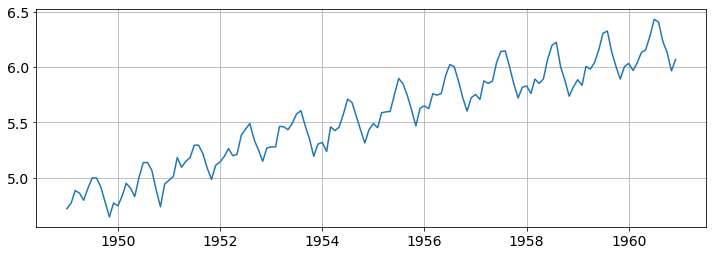

In [10]:
# Estimating trend
dataset_logscale = np.log(dataset)
plt.plot(dataset_logscale)
plt.show()

Results of Dickey Fuller test is :
Test statistic                  -1.717017
p_value                          0.422367
#Lags used                      13.000000
Number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64


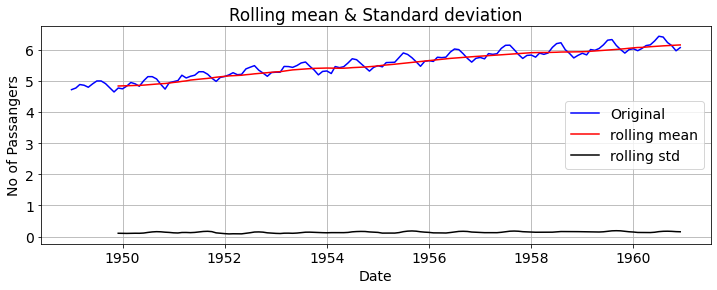

In [11]:
test_stationarity(dataset_logscale)

### 2. Substracting Simple Rolling Averages

In [12]:
movingAverage = dataset_logscale.rolling(window=12).mean()
dataset_logscale_minus_MA = dataset_logscale - movingAverage
dataset_logscale_minus_MA.head(5)

# removing the null values
dataset_logscale_minus_MA.dropna(inplace = True)
dataset_logscale_minus_MA.head(5)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


Results of Dickey Fuller test is :
Test statistic                  -3.162908
p_value                          0.022235
#Lags used                      13.000000
Number of observations used    119.000000
critical value (1%)             -3.486535
critical value (5%)             -2.886151
critical value (10%)            -2.579896
dtype: float64


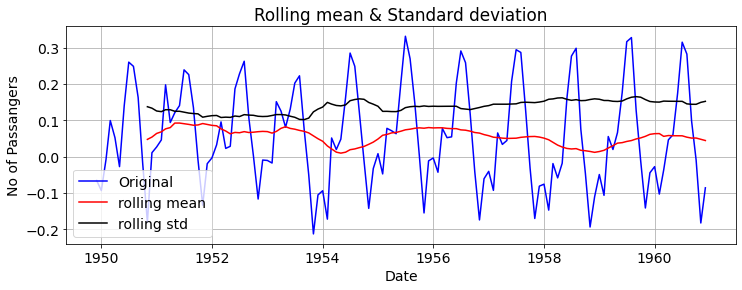

In [13]:
test_stationarity(dataset_logscale_minus_MA)

### 3. Differencing Exponential Moving Average

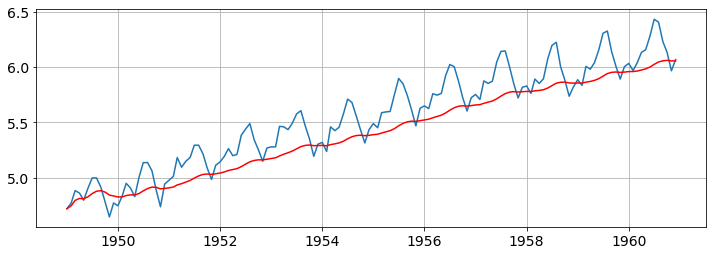

In [14]:
expo_decay_weightedAverage = dataset_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(dataset_logscale)
plt.plot(expo_decay_weightedAverage, color = 'red')
plt.show()

Results of Dickey Fuller test is :
Test statistic                  -3.601262
p_value                          0.005737
#Lags used                      13.000000
Number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64


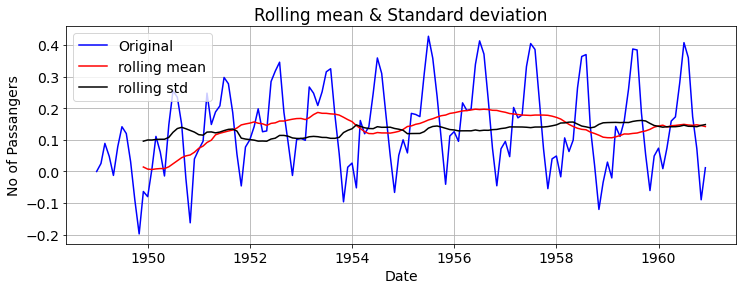

In [15]:
dataset_logscale_minus_expo_decay_weightedAverage = dataset_logscale - expo_decay_weightedAverage
test_stationarity(dataset_logscale_minus_expo_decay_weightedAverage)

### 4. Differencing Previous Value

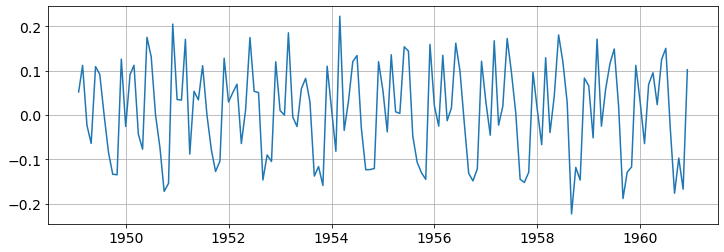

In [16]:
dataset_log_diffshifting = dataset_logscale - dataset_logscale.shift()
plt.plot(dataset_log_diffshifting)
plt.show()
#dataset_log_diffshifting.head()

Results of Dickey Fuller test is :
Test statistic                  -2.717131
p_value                          0.071121
#Lags used                      14.000000
Number of observations used    128.000000
critical value (1%)             -3.482501
critical value (5%)             -2.884398
critical value (10%)            -2.578960
dtype: float64


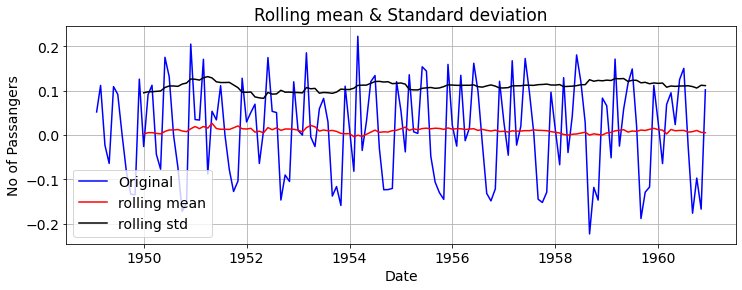

In [17]:
dataset_log_diffshifting.dropna(inplace = True)
test_stationarity(dataset_log_diffshifting)

### 5. Seasonal Decomposition

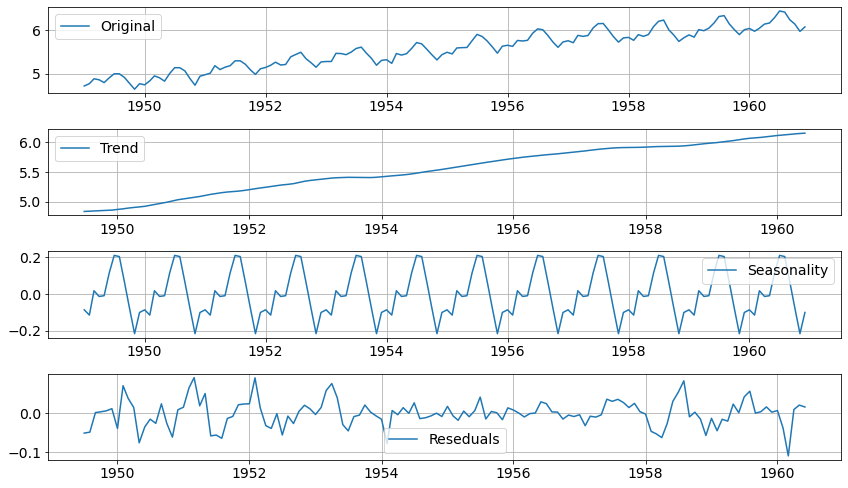

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,7))
plt.subplot(411)
plt.plot(dataset_logscale, label = 'Original')
plt.legend()
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(residual, label = 'Reseduals')
plt.legend()
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace = True)
#test_stationarity(decomposedLogData)
#decomposedLogData.columns = ['Date','Value']
#type(decomposedLogData)
#decomposedLogData.head()

### ARMA modelling

Auto Regressive Model:

    AR(1)---- p(today) = Mean + coeff* p(yesterday) + Noise 
    AR(2)---- p(today) = Mean + coeff1* p(yesterday)+ coeff2* p(d.b.yesterday) + Noise 
    
Moving Average Model:

    AR(1)---- p(today) = Mean + coeff* noise(yesterday) + Noise(today)
    AR(2)---- p(today) = Mean + coeff1* noise(yesterday)+ coeff2*noise(d.b.yesterday) + Noise(today)
    
ARMA Model:
    
    ARMA(1,1)---- p(t) = Mean+ coeff* p(t-1)+coeff* e(t-1)+e(t)
    ARMA(2,1)---- regression pf price of last two days + average of noise of last one day

We can find the best fit lags or numbers for the models AR and MA by using the ACF and PACF (Partial Auto Correlation Funtion - Direct Effect of previous values)

It works only for either AR or MA models and doesn't work for combination i.e ARMA

The Only way for ARMA model is to try out different combinations and find the best one. But need not to do it manuallly, we have a great tool in statistics or statsmodels called - arma_order_select_ic

In [19]:
from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(dataset_log_diffshifting)

C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


{'bic':             0           1           2
 0 -225.639206 -228.618781 -228.527575
 1 -226.497365 -229.756336 -250.375467
 2 -225.753257 -255.336996 -269.503740
 3 -222.137562 -252.308122 -249.418687
 4 -232.957928 -253.670744 -253.229736,
 'bic_min_order': (2, 2)}

### AR Model

Printing AR model


C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


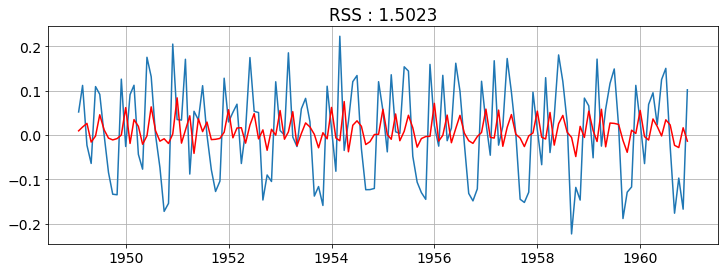

In [20]:
from statsmodels.tsa.arima_model import ARIMA
print("Printing AR model")
model = ARIMA(dataset_logscale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(dataset_log_diffshifting)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS : %.4f'% sum((results_AR.fittedvalues-dataset_log_diffshifting['#Passengers'])**2))
plt.show()

### MA Model

Printing MA model


C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


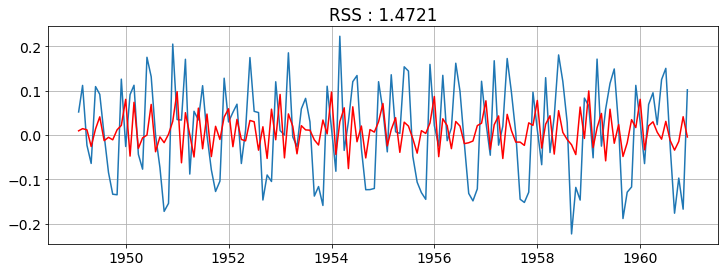

In [21]:
from statsmodels.tsa.arima_model import ARIMA
print("Printing MA model")
model = ARIMA(dataset_logscale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(dataset_log_diffshifting)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS : %.4f'% sum((results_MA.fittedvalues-dataset_log_diffshifting['#Passengers'])**2))
plt.show()

### ARIMA Model

In [22]:
import itertools
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [23]:
metric_dict = dict()
for pm in pdq:
    try:
        model = ARIMA(dataset_logscale, order=pm)
        model_aic = model.fit()
        rmse = sum((model_aic.fittedvalues-dataset_log_diffshifting['#Passengers'])**2)
        metric_dict.update({pm:rmse})

    except:
        continue

C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency in

C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency in

In [24]:
metric_dict.items()

dict_items([((0, 0, 0), nan), ((0, 0, 1), nan), ((0, 1, 0), 1.6122981858491325), ((0, 1, 1), 1.52453815803066), ((0, 1, 2), 1.4721401396447085), ((0, 2, 0), nan), ((0, 2, 1), nan), ((0, 2, 2), nan), ((1, 0, 0), nan), ((1, 0, 1), nan), ((1, 0, 2), nan), ((1, 1, 0), 1.5476170224844987), ((1, 1, 1), 1.4597312970259386), ((1, 1, 2), 1.2172999205633055), ((1, 2, 0), nan), ((2, 0, 0), nan), ((2, 0, 1), nan), ((2, 0, 2), nan), ((2, 1, 0), 1.5023033686506362), ((2, 1, 1), 1.1753125518163332), ((2, 1, 2), 1.029152006006465), ((2, 2, 0), nan), ((2, 2, 1), nan), ((2, 2, 2), nan)])

In [25]:
x = sorted(metric_dict.values())
y = [i for i in x if str(i)!= 'nan']
y

[1.4721401396447085,
 1.52453815803066,
 1.6122981858491325,
 1.2172999205633055,
 1.4597312970259386,
 1.5476170224844987,
 1.029152006006465,
 1.1753125518163332,
 1.5023033686506362]

In [26]:
minval = min(y)
res = [(k,v) for k, v in metric_dict.items() if v==minval]
res
#minval

[((2, 1, 2), 1.029152006006465)]

Printing ARIMA model


C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\SuresH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


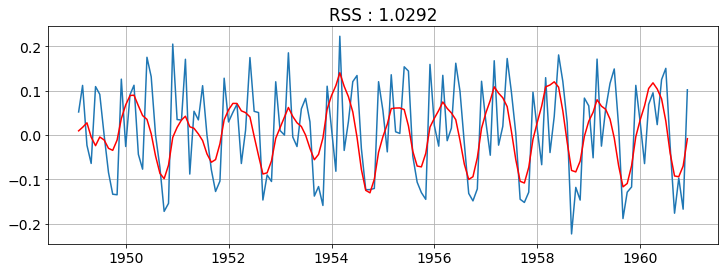

In [27]:
from statsmodels.tsa.arima_model import ARIMA
print("Printing ARIMA model")
model = ARIMA(dataset_logscale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(dataset_log_diffshifting)
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.title('RSS : %.4f'% sum((results_ARIMA.fittedvalues-dataset_log_diffshifting['#Passengers'])**2))
plt.show()

### Getting Predictions

In [28]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy = True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


#### Remember the predictons are in Log_differenced values. We need to convert them to original form

In [29]:
# convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [30]:
predictions_ARIMA_log = pd.Series(dataset_logscale['#Passengers'].iloc[0], index = dataset_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

#### To conert log form we use expontial

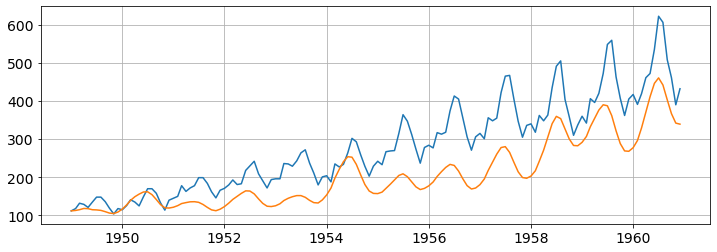

In [31]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(dataset)
plt.plot(predictions_ARIMA)
plt.show()

### How to get better results:
    - Use seasonal models - SARIMA
    - Use other features
    - Combining above two using SARIMAX